# Hyperparameter optimization

Most of the work in computational neuroscience is to guess the values of parameters which are not constrained by the biology. The most basic approach is to simply try out different values, run the simulation, reason about why the results are not what you want, change some parameters, run again, etc. It is very easy to get lost in this process and it requires a great deal of intuition about how the model works.

If you are able to define an objective function for your model (a single number that tells how well your model performs), you can use search algorithms to find this hyperparameters automatically, at the cost of running your model multiple times.

Let's take the example of a rate-coded model depending on two hyperparameters `a` and `b`, where is the objective is to have a minimal activity after 1 s of simulation (dummy example):

```python
from ANNarchy import *

pop = Population(...)
...
compile()

def run(a, b):
    pop.a = a
    pop.b = b
    
    simulate(1000.)
    
    return (pop.r)**2
```

**Grid search** would iterate over all possible values of the parameters to perform the search:

```python
min_loss = 1000.
for a in np.linspace(0.0, 1.0, 100):
    for b in np.linspace(0.0, 1.0, 100):
        loss = run(a, b)
        if loss < min_loss:
            min_loss = loss
            a_best = a ; b_best = b
```

If you try 100 values for each parameters, you need 10000 simulations to find your parameters. The number of simulations explodes with the number of free parameters. Moreover, you cannot stop the search before the end, as you could miss the interesting region.

**Random search** samples blindly values for the hyperparameters:

```python
min_loss = 1000.
for _ in range(1000):
    a = np.random.uniform(0.0, 1.0)
    b = np.random.uniform(0.0, 1.0)
    loss = run(a, b)
    if loss < min_loss:
        min_loss = loss
        a_best = a ; b_best = b
```

If you are lucky, you may find a good solution quite early in the search, so you can stop it when the loss is below a desired threshold. The main drawback is that the search may spend a lot of time in uninteresting regions: it does not learn anything between two samples.

An often much more efficient search method is **Bayesian optimization** (also called sequential model-based optimization - SMBO). It is a form of random search that updates beliefs on the hyperparameters. In short, if some parameter values do not lead to good values of the objective function in early samples, they will not be used in later samples. The search becomes more and more focused on the interesting regions of the hyperparameter space. 

As always with Python, there are many libraries for that, including:

* `hyperopt` <https://github.com/hyperopt/hyperopt>
* `optuna` <https://github.com/pfnet/optuna>
* `talos` (for keras models) <https://github.com/autonomio/talos>

This notebook demonstrates how to use `hyperopt` to find some hyperparameters of the COBA models already included in the ANNarchy examples:

<https://annarchy.readthedocs.io/en/stable/example/COBA.html>

Additionally, we will use the `tensorboard` extension to visualize the dependency between the parameters and the objective function.

In [1]:
from ANNarchy import *
from ANNarchy.extensions.tensorboard import Logger
clear()
setup(dt=0.1)

ANNarchy 4.6 (4.6.9b) on linux (posix). 


In [2]:
COBA = Neuron(
    parameters="""
        El = -60.0          : population
        Vr = -60.0          : population
        Erev_exc = 0.0      : population
        Erev_inh = -80.0    : population
        Vt = -50.0          : population
        tau = 20.0          : population
        tau_exc = 5.0       : population
        tau_inh = 10.0      : population
        I = 20.0            : population
    """,
    equations="""
        tau * dv/dt = (El - v) + g_exc * (Erev_exc - v) + g_inh * (Erev_inh - v ) + I

        tau_exc * dg_exc/dt = - g_exc
        tau_inh * dg_inh/dt = - g_inh
    """,
    spike = "v > Vt",
    reset = "v = Vr",
    refractory = 5.0
)

P = Population(geometry=4000, neuron=COBA)
Pe = P[:3200]
Pi = P[3200:]
P.v = Normal(-55.0, 5.0)
P.g_exc = Normal(4.0, 1.5)
P.g_inh = Normal(20.0, 12.0)

Ce = Projection(pre=Pe, post=P, target='exc')
Ce.connect_fixed_probability(weights=0.6, probability=0.02)
Ci = Projection(pre=Pi, post=P, target='inh')
Ci.connect_fixed_probability(weights=6.7, probability=0.02)

compile()

m = Monitor(P, ['spike'])

With the default parameters, the COBA network fires at around 20 Hz:

In [3]:
simulate(1000.0)
data = m.get('spike')
fr = m.mean_fr(data)
print(fr)

21.371


Let's suppose we now want the network to fire at 30 Hz. Which parameters should we change to obtain that value?

Many parameters might influence the firing rate of the network (if not all). Here, we make the assumption that the weight values for the excitatory connections (0.6) and inhibitory ones (6.7) are the most critical ones.

Let's start by importing `hyperopt` (after installing it with `pip install hyperopt`):

In [4]:
from hyperopt import fmin, tpe, hp, STATUS_OK

We define a `trial()` method taking values for the two hyperparameters as inputs. It starts by resetting the network, sets the excitatory and inhibitory weights to the desired value, simulates for one second, computes the mean firing rate of the population, logs the parameters and finally returns the objective function: the squared error between the recorded firing rate and 30 Hz.

In [5]:
logger = Logger()

def trial(args):
    
    # Retrieve the parameters
    w_exc = args[0]
    w_inh = args[1]
    
    # Reset the network
    reset()
    
    # Set the hyperparameters
    Ce.w = w_exc
    Ci.w = w_inh
    
    # Simulate 1 second
    simulate(1000.0)

    # Retrieve the spike recordings and the membrane potential
    spikes = m.get('spike')

    # Compute the population firing rate
    fr = m.mean_fr(spikes)
    
    # Compute a qudratic loss around 30 Hz
    loss = 0.001*(fr - 30.0)**2   
    
    # Log the parameters
    logger.add_parameters({'w_exc': w_exc, 'w_inh': w_inh},
                         {'loss': loss, 'firing_rate': fr})
    
    return {
        'loss': loss,
        'status': STATUS_OK,
        # -- store other results like this
        'fr': fr,
        }

Logging in runs/May29_16-16-16_machine


We can check that the default parameters indeed lead to a firing rate of 20 Hz:

In [6]:
trial([0.6, 6.7])

{'loss': 0.07445964100000002, 'status': 'ok', 'fr': 21.371}

We can now use `hyperopt` to find the hyperparameters making the network fire at 30 Hz.

The `fmin()` function takes:

* `fn`: the objective function for a set of parameters.
* `space`: the search space for the hyperparameters (the prior). 
* `algo`: which algorithm to use, either tpe.suggest or random.suggest
* `max_evals`: number of samples (simulations) to make.

Here, we will sample the excitatory weights between 0.1 and 1, the inhibitory ones between 1 and 10. Of course, the smaller the range, the better. Refer to the doc of hyperopt for other sampling priors.

In [7]:
best = fmin(
    fn=trial,
    space=[
        hp.uniform('w_exc', 0.1, 1.0), 
        hp.uniform('w_inh', 1.0, 10.0)
    ],
    algo=tpe.suggest,
    max_evals=100)
print(best)

100%|██████████| 100/100 [00:28<00:00,  3.57it/s, best loss: 2.3870249999999614e-05]
{'w_exc': 0.5561537559434969, 'w_inh': 4.216804637949686}


After 100 simulations, `hyperopt` returns a set of hyperparameter values that make the network fire at 30Hz. We can check that it is true with:

In [8]:
trial([best['w_exc'], best['w_inh']])

{'loss': 2.3870249999999614e-05, 'status': 'ok', 'fr': 30.1545}

There are plenty of options to `hyperopt` (check Trials or the parallel search using MongoDB), but this simple example should get you started. 

If we start tensorboard in the default directory `runs/`, we can additionally visualize how the firing rate depends on `w_exc` and `w_inh` in the `HPARAMS` tab.

In [ ]:
logger.close()
%load_ext tensorboard
%tensorboard --logdir runs

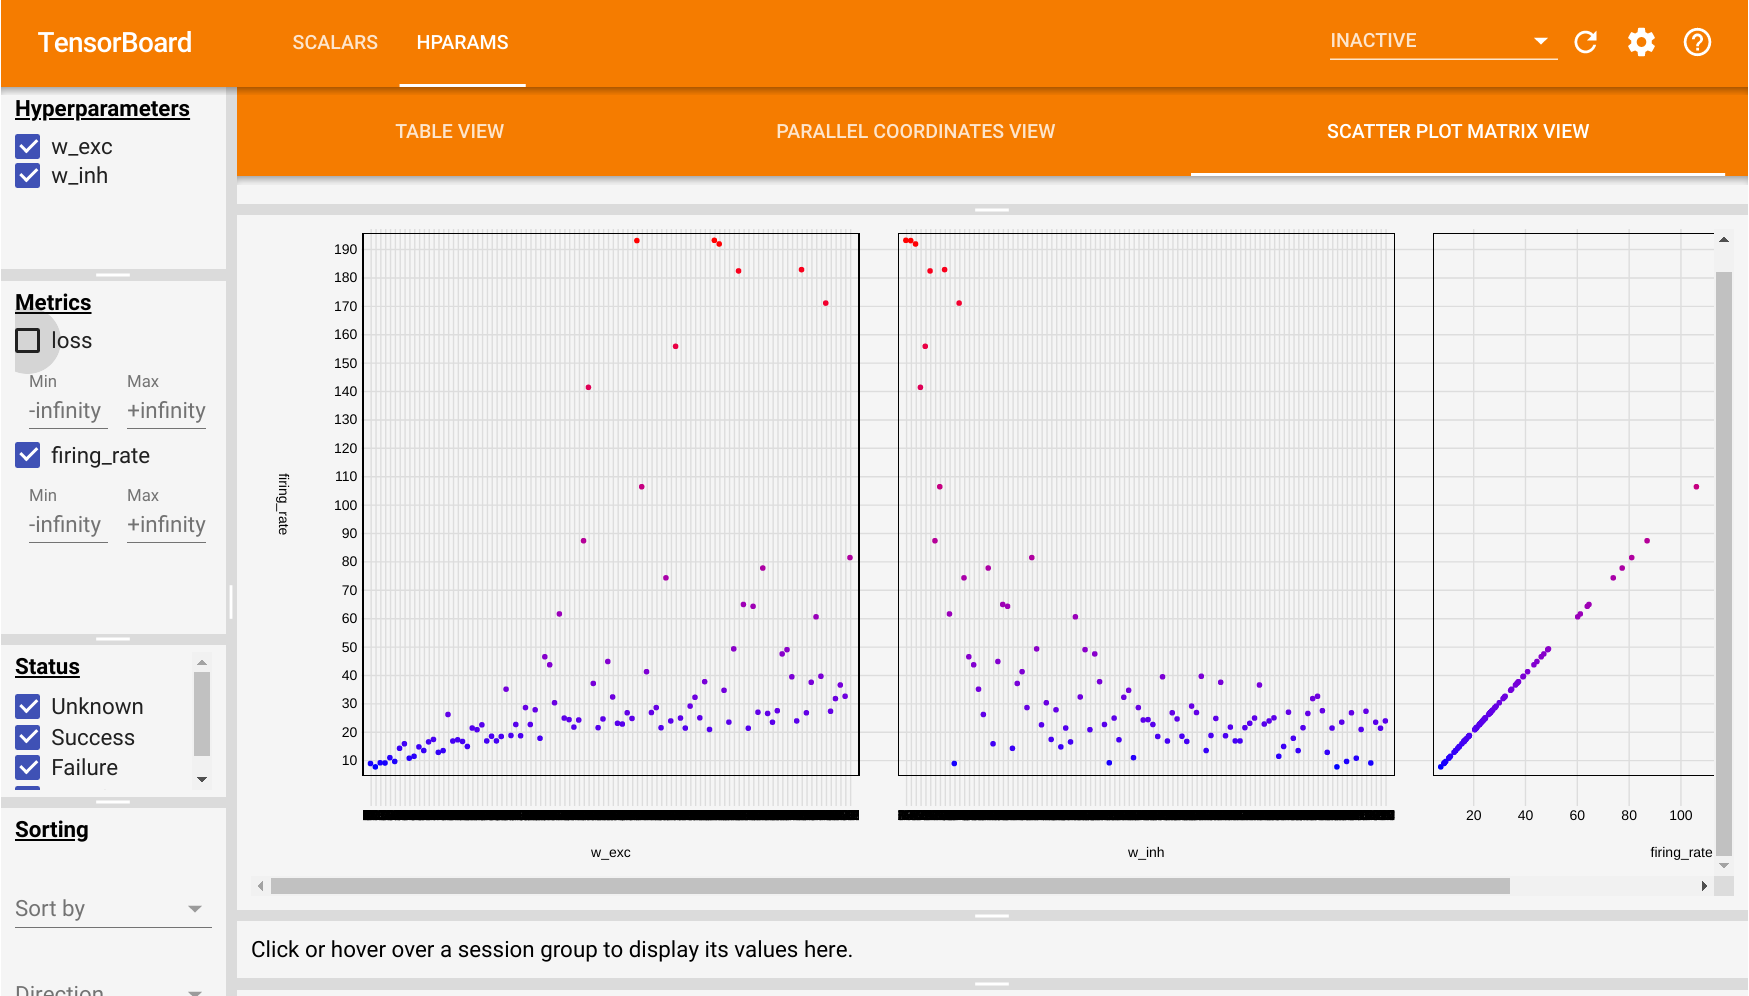{width=100%}